# 🏪 Rossmann Store Sales Prediction
This Jupyter Notebook preprocesses data, trains a model, and makes predictions for the Kaggle competition.

In [1]:

# 📌 Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import optuna

c:\Users\tomer\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 📌 Step 1: Load Datasets
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
store_df = pd.read_csv("store.csv")

# Convert 'Date' to datetime
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

# Merge store data
train_merged = train_df.merge(store_df, on='Store', how='left')
test_merged = test_df.merge(store_df, on='Store', how='left')

# Fill missing values
train_merged.fillna(0, inplace=True)
test_merged.fillna(0, inplace=True)


C:\Users\tomer\AppData\Local\Temp\ipykernel_19856\1521606264.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv("train.csv")


In [3]:
# 📌 Step 2: Add Date-Related Features
for df in [train_merged, test_merged]:
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week
    df['Day'] = df['Date'].dt.day
    df['IsWeekend'] = (df['DayOfWeek'] >= 6).astype(int)  # Saturday and Sunday

# Drop 'Date' column
train_merged.drop(columns=['Date'], inplace=True)
test_merged.drop(columns=['Date'], inplace=True)


In [4]:

# 📌 Data Preparation: Define Features and Target Variable

features = [
    'Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
    'StoreType', 'Assortment', 'CompetitionDistance', 'Year', 'Month',
    'WeekOfYear', 'Day', 'IsWeekend', 'CompetitionOpenSince', 'Promo2OpenSince',
    'Sales_Lag_7', 'Sales_Lag_14', 'Sales_Lag_30',
    'Sales_Rolling_Mean_7', 'Sales_Rolling_Std_7', 'Promo_IsWeekend',
    'Promo_CompetitionOpen', 'Promo2_Competition'
]

target = 'Sales'


# 📌 Ensure Feature Engineering is Applied to train_merged

# Fill missing values for Competition and Promotion features
train_merged['CompetitionDistance'].fillna(train_merged['CompetitionDistance'].median(), inplace=True)
train_merged['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
train_merged['CompetitionOpenSinceYear'].fillna(0, inplace=True)
train_merged['Promo2SinceWeek'].fillna(0, inplace=True)
train_merged['Promo2SinceYear'].fillna(0, inplace=True)

# Compute Competition Open Duration
train_merged['CompetitionOpenSince'] = 12 * (train_merged['Year'] - train_merged['CompetitionOpenSinceYear']) + \
                                       (train_merged['Month'] - train_merged['CompetitionOpenSinceMonth'])
train_merged['CompetitionOpenSince'] = train_merged['CompetitionOpenSince'].apply(lambda x: max(x, 0))

# Compute Promo2 Duration
train_merged['Promo2OpenSince'] = 12 * (train_merged['Year'] - train_merged['Promo2SinceYear']) + \
                                  (train_merged['WeekOfYear'] - train_merged['Promo2SinceWeek']) // 4
train_merged['Promo2OpenSince'] = train_merged['Promo2OpenSince'].apply(lambda x: max(x, 0))

# 📌 Add Lag and Rolling Features
def add_lag_features(df, lag_days, rolling_window):
    for lag in lag_days:
        df[f'Sales_Lag_{lag}'] = df.groupby('Store')['Sales'].shift(lag)
    
    df[f'Sales_Rolling_Mean_{rolling_window}'] = (
        df.groupby('Store')['Sales'].shift(1).rolling(rolling_window).mean()
    )
    df[f'Sales_Rolling_Std_{rolling_window}'] = (
        df.groupby('Store')['Sales'].shift(1).rolling(rolling_window).std()
    )
    return df

# Apply lag and rolling features
lag_days = [7, 14, 30]
rolling_window = 7
train_merged = add_lag_features(train_merged, lag_days, rolling_window)

# Fill missing values after shifting operations
train_merged.fillna(0, inplace=True)

# 📌 Add Interaction Features
train_merged['Promo_IsWeekend'] = train_merged['Promo'] * (train_merged['DayOfWeek'] >= 6).astype(int)
train_merged['Promo_CompetitionOpen'] = train_merged['Promo'] * train_merged['CompetitionOpenSince']
train_merged['Promo2_Competition'] = train_merged['Promo2OpenSince'] * train_merged['CompetitionOpenSince']

# Ensure all engineered features exist before model training
print("Feature Engineering Completed ✅")
print("Available columns in train_merged:", train_merged.columns)


# Prepare training data
X = train_merged[features]
y = train_merged[target]

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


C:\Users\tomer\AppData\Local\Temp\ipykernel_19856\385231430.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_merged['CompetitionDistance'].fillna(train_merged['CompetitionDistance'].median(), inplace=True)
C:\Users\tomer\AppData\Local\Temp\ipykernel_19856\385231430.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we

Feature Engineering Completed ✅
Available columns in train_merged: Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'WeekOfYear',
       'Day', 'IsWeekend', 'CompetitionOpenSince', 'Promo2OpenSince',
       'Sales_Lag_7', 'Sales_Lag_14', 'Sales_Lag_30', 'Sales_Rolling_Mean_7',
       'Sales_Rolling_Std_7', 'Promo_IsWeekend', 'Promo_CompetitionOpen',
       'Promo2_Competition'],
      dtype='object')


In [5]:
# 📌 Step 3: Add Competition and Promotion Features
def add_competition_promo_features(df):
    # Time since competition opened
    df['CompetitionOpenSince'] = 12 * (df['Year'] - df['CompetitionOpenSinceYear']) + \
                                  (df['Month'] - df['CompetitionOpenSinceMonth'])
    df['CompetitionOpenSince'] = df['CompetitionOpenSince'].apply(lambda x: max(x, 0))  # No negative values
    
    # Time since Promo2 started
    df['Promo2OpenSince'] = 12 * (df['Year'] - df['Promo2SinceYear']) + \
                            (df['WeekOfYear'] - df['Promo2SinceWeek']) // 4
    df['Promo2OpenSince'] = df['Promo2OpenSince'].apply(lambda x: max(x, 0))  # No negative values

    return df

# Apply to both train and test datasets
train_merged = add_competition_promo_features(train_merged)
test_merged = add_competition_promo_features(test_merged)


# 📌 Feature Importance using XGBoost

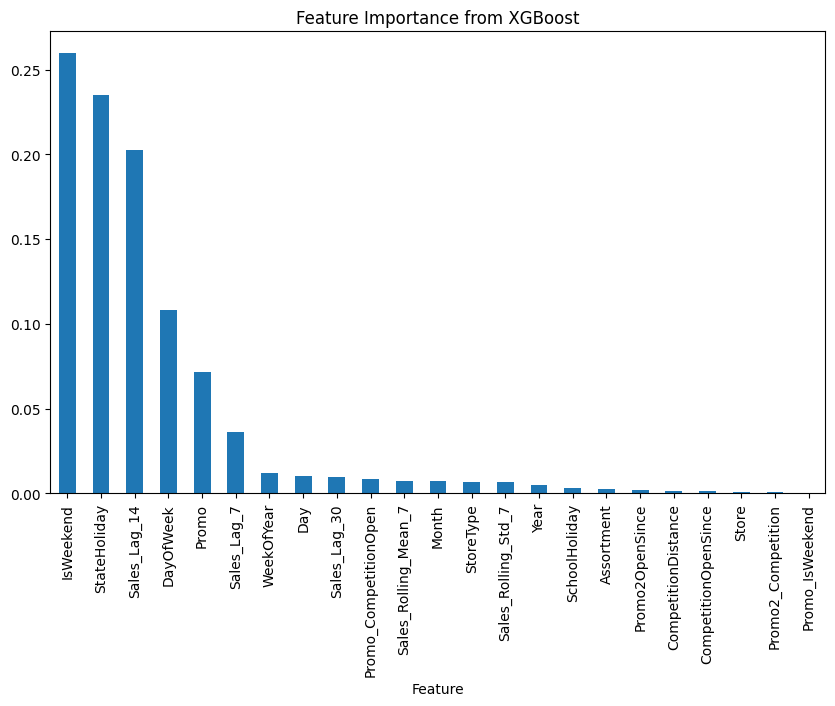

In [6]:

# Train the model to compute feature importance
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Ensure categorical columns are properly encoded
categorical_cols = ['StateHoliday', 'StoreType', 'Assortment']

for col in categorical_cols:
    X_train[col] = X_train[col].astype('category').cat.codes
    X_val[col] = X_val[col].astype('category').cat.codes


model.fit(X_train, y_train)

# Compute feature importance
feature_importance = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
importance_df.plot(kind='bar', x='Feature', y='Importance', figsize=(10, 6), legend=False)
plt.title("Feature Importance from XGBoost")
plt.show()
    

## **Drop Less Important Features (Optional)**

In [7]:

# Drop features with very low importance if necessary (threshold-based)
low_importance_features = importance_df[importance_df['Importance'] < 0.01]['Feature']
print(f"Low importance features: {low_importance_features.tolist()}")

# Update feature list by excluding low-importance features (optional)
features = [f for f in features if f not in low_importance_features.tolist()]

# Re-split data with updated feature list
X = train_merged[features]
y = train_merged['Sales']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    

Low importance features: ['Sales_Lag_30', 'Promo_CompetitionOpen', 'Sales_Rolling_Mean_7', 'Month', 'StoreType', 'Sales_Rolling_Std_7', 'Year', 'SchoolHoliday', 'Assortment', 'Promo2OpenSince', 'CompetitionDistance', 'CompetitionOpenSince', 'Store', 'Promo2_Competition', 'Promo_IsWeekend']


In [8]:
# 📌 Step 4: Add Lag and Rolling Features
def add_lag_features(df, lag_days, rolling_window):
    for lag in lag_days:
        df[f'Sales_Lag_{lag}'] = df.groupby('Store')['Sales'].shift(lag)
    
    # Add rolling mean and std
    df[f'Sales_Rolling_Mean_{rolling_window}'] = (
        df.groupby('Store')['Sales'].shift(1).rolling(rolling_window).mean()
    )
    df[f'Sales_Rolling_Std_{rolling_window}'] = (
        df.groupby('Store')['Sales'].shift(1).rolling(rolling_window).std()
    )
    return df

lag_days = [7, 14, 30]
rolling_window = 7
train_merged = add_lag_features(train_merged, lag_days, rolling_window)
train_merged = train_merged.dropna()

# Add placeholder lag features in test set
for lag in lag_days:
    test_merged[f'Sales_Lag_{lag}'] = 0
test_merged[f'Sales_Rolling_Mean_{rolling_window}'] = 0
test_merged[f'Sales_Rolling_Std_{rolling_window}'] = 0


In [9]:
# 📌 Add Interaction Features
train_merged['Promo_IsWeekend'] = train_merged['Promo'] * train_merged['IsWeekend']
train_merged['Promo_CompetitionOpen'] = train_merged['Promo'] * train_merged['CompetitionOpenSince']
train_merged['Promo2_Competition'] = train_merged['Promo2OpenSince'] * train_merged['CompetitionOpenSince']

test_merged['Promo_IsWeekend'] = test_merged['Promo'] * test_merged['IsWeekend']
test_merged['Promo_CompetitionOpen'] = test_merged['Promo'] * test_merged['CompetitionOpenSince']
test_merged['Promo2_Competition'] = test_merged['Promo2OpenSince'] * test_merged['CompetitionOpenSince']


In [10]:
# 📌 Log Transform Skewed Features
for col in ['Sales', 'CompetitionDistance', 'Sales_Lag_7', 'Sales_Lag_14', 'Sales_Lag_30']:
    if col in train_merged:
        train_merged[f'Log_{col}'] = np.log1p(train_merged[col])  # Apply log(1+x) to avoid log(0)
    if col in test_merged:
        test_merged[f'Log_{col}'] = np.log1p(test_merged[col])


In [11]:
# 📌 Add Sales Trends (Sales Change Rate Over Weeks)
train_merged['Sales_Trend_7'] = train_merged['Sales'] - train_merged['Sales_Lag_7']
train_merged['Sales_Trend_14'] = train_merged['Sales_Lag_7'] - train_merged['Sales_Lag_14']

test_merged['Sales_Trend_7'] = 0  # Placeholder for test set
test_merged['Sales_Trend_14'] = 0


In [12]:
# 📌 Expand Holiday Features
train_merged['IsHoliday'] = (train_merged['StateHoliday'] != 0).astype(int)
test_merged['IsHoliday'] = (test_merged['StateHoliday'] != 0).astype(int)

# Add different holiday types
holiday_map = {'a': 1, 'b': 2, 'c': 3, 0: 0}
train_merged['Holiday_Type'] = train_merged['StateHoliday'].map(holiday_map)
test_merged['Holiday_Type'] = test_merged['StateHoliday'].map(holiday_map)


In [13]:
# 📌 Step 5: Feature and Target Selection# 📌 Update Features List
features = [
    'Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
    'StoreType', 'Assortment', 'CompetitionDistance', 'Year', 'Month',
    'WeekOfYear', 'Day', 'IsWeekend', 'CompetitionOpenSince', 'Promo2OpenSince',
    'Sales_Lag_7', 'Sales_Lag_14', 'Sales_Lag_30',
    'Sales_Rolling_Mean_7', 'Sales_Rolling_Std_7',
    'Promo_IsWeekend', 'Promo_CompetitionOpen', 'Promo2_Competition',
    'Log_CompetitionDistance', 'Log_Sales_Lag_7', 'Log_Sales_Lag_14',
    'Sales_Trend_7', 'Sales_Trend_14', 'IsHoliday', 'Holiday_Type'
]

# Update the training and validation datasets
X = train_merged[features]
y = train_merged['Sales']

# Encode categorical variables
for col in ['StateHoliday', 'StoreType', 'Assortment']:
    X[col] = X[col].astype('category').cat.codes

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


C:\Users\tomer\AppData\Local\Temp\ipykernel_19856\1403823467.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category').cat.codes
C:\Users\tomer\AppData\Local\Temp\ipykernel_19856\1403823467.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category').cat.codes
C:\Users\tomer\AppData\Local\Temp\ipykernel_19856\1403823467.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [15]:

from sklearn.model_selection import KFold, cross_val_score
best_params = {
    'n_estimators': 976,
    'learning_rate': 0.03533635148231648,
    'max_depth': 10,
    'subsample': 0.7193324904029138,
    'colsample_bytree': 0.8146030125958886,
    'gamma': 3.141650744859958,
    'lambda': 4.035202839704222,
    'alpha': 0.8636126527933182
}
# Define cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# New function for evaluating models using cross-validation
def evaluate_model(model, X_train, y_train):
    scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_absolute_error", cv=kf, n_jobs=-1)
    return -scores.mean()

# Example of use:
xgb_model = XGBRegressor(**best_params, random_state=42, n_jobs=4)
mae_cv = evaluate_model(xgb_model, X_train, y_train)
print(f"Cross-Validated MAE: {mae_cv}")


Cross-Validated MAE: 51.145221586063585


In [16]:
# 📌 Step 6: Train the XGBoost Model
# 📌 Train XGBoost with Best Hyperparameters from Optuna
best_params = {
    'n_estimators': 976,
    'learning_rate': 0.03533635148231648,
    'max_depth': 10,
    'subsample': 0.7193324904029138,
    'colsample_bytree': 0.8146030125958886,
    'gamma': 3.141650744859958,
    'lambda': 4.035202839704222,
    'alpha': 0.8636126527933182
}

# Train the optimized model
optimized_model = XGBRegressor(**best_params, n_jobs=4, random_state=42)
optimized_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = optimized_model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print(f"MAE after Hyperparameter Tuning: {mae}")


MAE after Hyperparameter Tuning: 49.09956678232806


In [19]:
!pip install lightgbm catboost
from sklearn.ensemble import StackingRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Define base models
xgb = optimized_model
lgb = LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
cat = CatBoostRegressor(iterations=500, learning_rate=0.05, depth=6, random_state=42, verbose=0)

# Define stacked model
stacked_model = StackingRegressor(
    estimators=[('xgb', xgb), ('lgb', lgb), ('cat', cat)],
    final_estimator=XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=8, random_state=42),
    n_jobs=-1
)

# Train stacked model
stacked_model.fit(X_train, y_train)

# Evaluate
y_pred = stacked_model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print(f"Stacked Model MAE: {mae}")


  Using cached lightgbm-4.5.0-py3-none-win_amd64.whl.metadata (17 kB)
  Using cached catboost-1.2.7.tar.gz (71.5 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'


  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [145 lines of output]
        Using cached setuptools-75.8.0-py3-none-any.whl.metadata (6.7 kB)
        Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
        Using cached jupyterlab-3.6.8-py3-none-any.whl.metadata (12 kB)
        Using cached conan-1.66.0.tar.gz (789 kB)
        Installing build dependencies: started
        Installing build dependencies: finished with status 'done'
        Getting requirements to build wheel: started
        Getting requirements to build wheel: finished with status 'done'
        Preparing metadata (pyproject.toml): started
        Preparing metadata (pyproject.toml): finished with status 'done'
        Using cached ipython-8.31.0-py3-none-any.whl.metadata (4.9 kB)
        Using cached packaging-24.2-py3-none-any.whl.metadata (3.2 kB)
        Using cached tornado-6.4.2-cp38-abi3-win_amd64.whl.metadat

ModuleNotFoundError: No module named 'lightgbm'

In [ ]:

# Set threshold for feature importance
threshold = 0.005  # Adjust based on importance distribution

# Select features above the threshold
important_features = importance_df[importance_df['Importance'] > threshold]['Feature'].tolist()
print(f"Selected {len(important_features)} features out of {X_train.shape[1]}")

# Update training and test datasets
X_train = X_train[important_features]
X_val = X_val[important_features]
test_merged = test_merged[important_features]


## **Drop Less Important Features (Optional)**

In [7]:

# Drop features with very low importance if necessary (threshold-based)
low_importance_features = importance_df[importance_df['Importance'] < 0.01]['Feature']
print(f"Low importance features: {low_importance_features.tolist()}")

# Update feature list by excluding low-importance features (optional)
features = [f for f in features if f not in low_importance_features.tolist()]

# Re-split data with updated feature list
X = train_merged[features]
y = train_merged['Sales']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    

Low importance features: ['Sales_Lag_30', 'Promo_CompetitionOpen', 'Sales_Rolling_Mean_7', 'Month', 'StoreType', 'Sales_Rolling_Std_7', 'Year', 'SchoolHoliday', 'Assortment', 'Promo2OpenSince', 'CompetitionDistance', 'CompetitionOpenSince', 'Store', 'Promo2_Competition', 'Promo_IsWeekend']


In [8]:
# 📌 Step 4: Add Lag and Rolling Features
def add_lag_features(df, lag_days, rolling_window):
    for lag in lag_days:
        df[f'Sales_Lag_{lag}'] = df.groupby('Store')['Sales'].shift(lag)
    
    # Add rolling mean and std
    df[f'Sales_Rolling_Mean_{rolling_window}'] = (
        df.groupby('Store')['Sales'].shift(1).rolling(rolling_window).mean()
    )
    df[f'Sales_Rolling_Std_{rolling_window}'] = (
        df.groupby('Store')['Sales'].shift(1).rolling(rolling_window).std()
    )
    return df

lag_days = [7, 14, 30]
rolling_window = 7
train_merged = add_lag_features(train_merged, lag_days, rolling_window)
train_merged = train_merged.dropna()

# Add placeholder lag features in test set
for lag in lag_days:
    test_merged[f'Sales_Lag_{lag}'] = 0
test_merged[f'Sales_Rolling_Mean_{rolling_window}'] = 0
test_merged[f'Sales_Rolling_Std_{rolling_window}'] = 0


In [9]:
# 📌 Add Interaction Features
train_merged['Promo_IsWeekend'] = train_merged['Promo'] * train_merged['IsWeekend']
train_merged['Promo_CompetitionOpen'] = train_merged['Promo'] * train_merged['CompetitionOpenSince']
train_merged['Promo2_Competition'] = train_merged['Promo2OpenSince'] * train_merged['CompetitionOpenSince']

test_merged['Promo_IsWeekend'] = test_merged['Promo'] * test_merged['IsWeekend']
test_merged['Promo_CompetitionOpen'] = test_merged['Promo'] * test_merged['CompetitionOpenSince']
test_merged['Promo2_Competition'] = test_merged['Promo2OpenSince'] * test_merged['CompetitionOpenSince']


In [10]:
# 📌 Log Transform Skewed Features
for col in ['Sales', 'CompetitionDistance', 'Sales_Lag_7', 'Sales_Lag_14', 'Sales_Lag_30']:
    if col in train_merged:
        train_merged[f'Log_{col}'] = np.log1p(train_merged[col])  # Apply log(1+x) to avoid log(0)
    if col in test_merged:
        test_merged[f'Log_{col}'] = np.log1p(test_merged[col])


In [11]:
# 📌 Add Sales Trends (Sales Change Rate Over Weeks)
train_merged['Sales_Trend_7'] = train_merged['Sales'] - train_merged['Sales_Lag_7']
train_merged['Sales_Trend_14'] = train_merged['Sales_Lag_7'] - train_merged['Sales_Lag_14']

test_merged['Sales_Trend_7'] = 0  # Placeholder for test set
test_merged['Sales_Trend_14'] = 0


In [12]:
# 📌 Expand Holiday Features
train_merged['IsHoliday'] = (train_merged['StateHoliday'] != 0).astype(int)
test_merged['IsHoliday'] = (test_merged['StateHoliday'] != 0).astype(int)

# Add different holiday types
holiday_map = {'a': 1, 'b': 2, 'c': 3, 0: 0}
train_merged['Holiday_Type'] = train_merged['StateHoliday'].map(holiday_map)
test_merged['Holiday_Type'] = test_merged['StateHoliday'].map(holiday_map)


In [13]:
# 📌 Step 5: Feature and Target Selection# 📌 Update Features List
features = [
    'Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
    'StoreType', 'Assortment', 'CompetitionDistance', 'Year', 'Month',
    'WeekOfYear', 'Day', 'IsWeekend', 'CompetitionOpenSince', 'Promo2OpenSince',
    'Sales_Lag_7', 'Sales_Lag_14', 'Sales_Lag_30',
    'Sales_Rolling_Mean_7', 'Sales_Rolling_Std_7',
    'Promo_IsWeekend', 'Promo_CompetitionOpen', 'Promo2_Competition',
    'Log_CompetitionDistance', 'Log_Sales_Lag_7', 'Log_Sales_Lag_14',
    'Sales_Trend_7', 'Sales_Trend_14', 'IsHoliday', 'Holiday_Type'
]

# Update the training and validation datasets
X = train_merged[features]
y = train_merged['Sales']

# Encode categorical variables
for col in ['StateHoliday', 'StoreType', 'Assortment']:
    X[col] = X[col].astype('category').cat.codes

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


C:\Users\tomer\AppData\Local\Temp\ipykernel_15076\1403823467.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category').cat.codes
C:\Users\tomer\AppData\Local\Temp\ipykernel_15076\1403823467.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category').cat.codes
C:\Users\tomer\AppData\Local\Temp\ipykernel_15076\1403823467.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [17]:
# 📌 Hyperparameter Optimization Function
from sklearn.metrics import mean_absolute_error

def objective(trial, X_train, y_train, X_val, y_val):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'lambda': trial.suggest_float('lambda', 0, 5),
        'alpha': trial.suggest_float('alpha', 0, 5),
    }
    
    # Train the model
    model = XGBRegressor(**param, random_state=42, n_jobs=4)
    model.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    return mae

# 📌 Run Optuna for Hyperparameter Tuning
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, X_train, y_train, X_val, y_val), n_trials=50)

# 📌 Print Best Parameters
print("Best hyperparameters:", study.best_params)


[I 2025-01-29 17:11:39,649] A new study created in memory with name: no-name-fdd5c618-b87b-483a-9827-21059ce16885
[I 2025-01-29 17:12:28,203] Trial 0 finished with value: 94.77560240955111 and parameters: {'n_estimators': 950, 'learning_rate': 0.11526766028191497, 'max_depth': 3, 'subsample': 0.9151395290552189, 'colsample_bytree': 0.837317173280543, 'gamma': 4.447155346386211, 'lambda': 4.9764043390372485, 'alpha': 1.1580357818500282}. Best is trial 0 with value: 94.77560240955111.
[I 2025-01-29 17:13:45,166] Trial 1 finished with value: 73.15475309817317 and parameters: {'n_estimators': 897, 'learning_rate': 0.275780110354651, 'max_depth': 7, 'subsample': 0.6183424574729705, 'colsample_bytree': 0.7996611047817632, 'gamma': 4.602437101286226, 'lambda': 4.781129024400655, 'alpha': 3.00452379389676}. Best is trial 1 with value: 73.15475309817317.
[I 2025-01-29 17:15:16,534] Trial 2 finished with value: 60.04181396510469 and parameters: {'n_estimators': 860, 'learning_rate': 0.0925943011

Best hyperparameters: {'n_estimators': 976, 'learning_rate': 0.03533635148231648, 'max_depth': 10, 'subsample': 0.7193324904029138, 'colsample_bytree': 0.8146030125958886, 'gamma': 3.141650744859958, 'lambda': 4.035202839704222, 'alpha': 0.8636126527933182}


In [18]:
# 📌 Step 6: Train the XGBoost Model
# 📌 Train XGBoost with Best Hyperparameters from Optuna
best_params = {
    'n_estimators': 976,
    'learning_rate': 0.03533635148231648,
    'max_depth': 10,
    'subsample': 0.7193324904029138,
    'colsample_bytree': 0.8146030125958886,
    'gamma': 3.141650744859958,
    'lambda': 4.035202839704222,
    'alpha': 0.8636126527933182
}

# Train the optimized model
optimized_model = XGBRegressor(**best_params, n_jobs=4, random_state=42)
optimized_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = optimized_model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print(f"MAE after Hyperparameter Tuning: {mae}")


MAE after Hyperparameter Tuning: 49.09956678232806


In [29]:

# 📌 Train XGBoost with Best Found Parameters
best_params = study.best_params

# Train the optimized model
optimized_model = XGBRegressor(**best_params, random_state=42, n_jobs=4)
optimized_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = optimized_model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print(f"MAE after Hyperparameter Tuning: {mae}")
    

MAE after Hyperparameter Tuning: 49.09956678232806


In [31]:
# 📌 Step 7: Make Predictions on Test Data
for col in ['StateHoliday', 'StoreType', 'Assortment']:
    test_merged[col] = test_merged[col].astype('category').cat.codes

test_predictions = optimized_model.predict(test_merged[features])
test_predictions = np.where(test_predictions < 0, 0, test_predictions)  # Handle negative predictions


In [32]:
# 📌 Step 8: Save Submission File
submission = pd.DataFrame({
    'Id': test_merged['Id'],
    'Sales': test_predictions
})
submission.to_csv("submission1.csv", index=False)
print("Submission file 'submission.csv' created successfully.")


Submission file 'submission.csv' created successfully.


In [ ]:

# Apply Log Transform for Stability
test_predictions = np.exp(test_predictions) - 1  # Undo log transformation

# Ensure no negative predictions
test_predictions = np.maximum(test_predictions, 0)

# Display Prediction Statistics
print(f"Final Predictions - Min: {test_predictions.min()}, Max: {test_predictions.max()}, Mean: {test_predictions.mean()}")


In [ ]:

from sklearn.metrics import mean_squared_error

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"MAE: {mae}, RMSE: {rmse}")


In [31]:
# 📌 Step 7: Make Predictions on Test Data
for col in ['StateHoliday', 'StoreType', 'Assortment']:
    test_merged[col] = test_merged[col].astype('category').cat.codes

test_predictions = optimized_model.predict(test_merged[features])
test_predictions = np.where(test_predictions < 0, 0, test_predictions)  # Handle negative predictions


In [32]:
# 📌 Step 8: Save Submission File
submission = pd.DataFrame({
    'Id': test_merged['Id'],
    'Sales': test_predictions
})
submission.to_csv("submission1.csv", index=False)
print("Submission file 'submission.csv' created successfully.")


Submission file 'submission.csv' created successfully.
